Author : Kraemer Valentin 

Date : 25 november 2023

Desc : data frame analysis 

# Analyse de la relation angle du levier et angle d'attaque (provenant des vitesses horizontales et verticales)


**modules utiles**



In [3]:
%reload_ext autoreload
%autoreload 2

# module
import sys
sys.path.append("../")
from src import * 

# chemin vers la donnee 
data_dir = '/home/valentin/Documents/Cours/MACS/MACS3/madane/data/data_extracted/'
filelist = glob.glob(data_dir + '*.h5')


# Avion
_PLANE = 0
ddf = lire_hdf_dask(filelist[_PLANE], repertoire= data_dir)

# VOL
_VOL = 0 

*facteurs de conversion*

In [5]:
MachToFeetS = 1125.33

## Extraction du dataframe

In [7]:
df = ddf.partitions[_VOL].compute()

### Fonctions utiles de manipulation de dataframe 

**Ajout des vitesses dans le dataframe**

On implémente la fonction suivante permettant d'obtenir des vitesses en ft/s

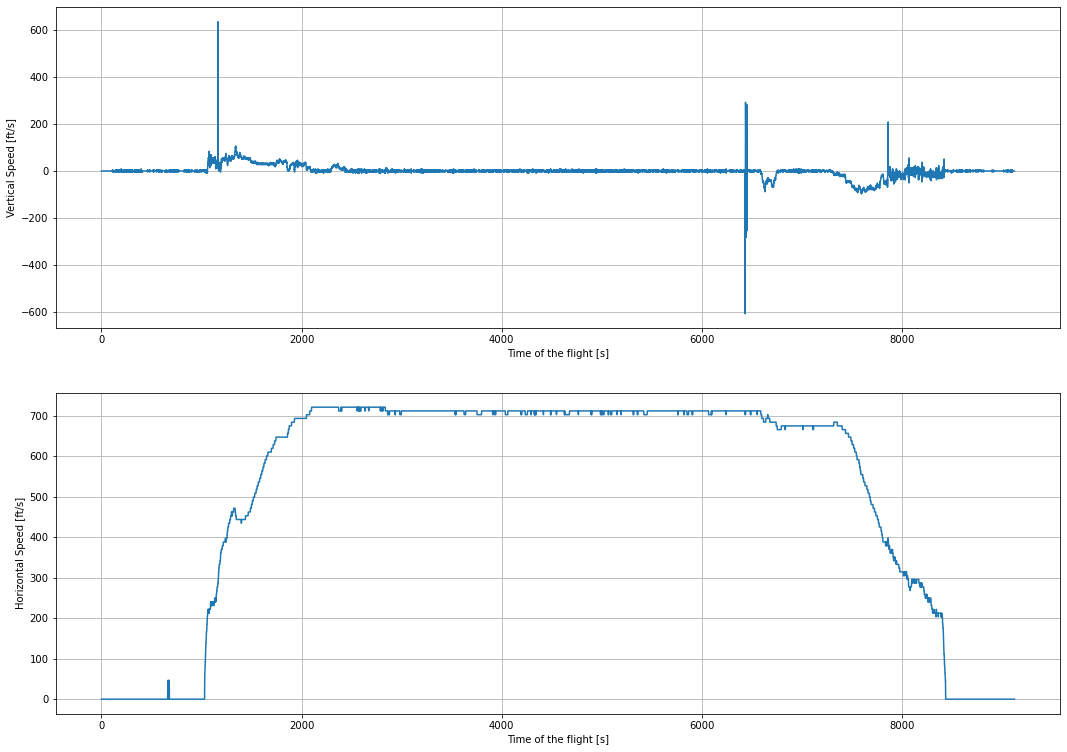

In [16]:
def add_speed(df) :
    ON_AIR = df['M [Mach]']>0
    dy= np.empty(len(df))
    y = df['ALT [ft]'].values
    dy[:-1] = y[1:]-y[:-1]
    dy[-1]=0
    df['dy [ft/s]'] =dy
    df['dx [ft/s]'] = df['M [Mach]']*MachToFeetS
    df['ON_AIR'] = ON_AIR
    return df

# output 
df_speed = add_speed(df)


# affichage graphique 
nb_of_plots = 2
fig, axs = plt.subplots(nb_of_plots, figsize = (18,13))
df_speed['dy [ft/s]'].plot(ax= axs[0], grid = True)
df_speed['dx [ft/s]'].plot(ax = axs[1], grid = True)

labs = ['Vertical Speed [ft/s]', 'Horizontal Speed [ft/s]']
for i, lab in enumerate(labs):
    axs[i].set_ylabel(lab)
    axs[i].set_xlabel('Time of the flight [s]')

# brouillon

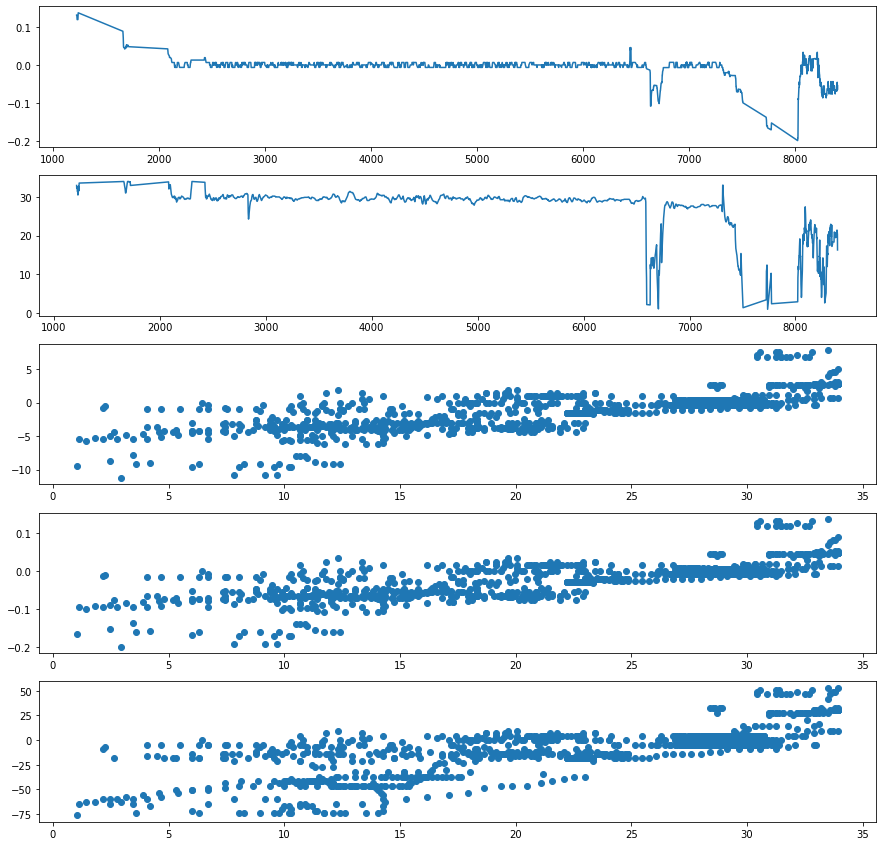

In [45]:
id_on_air = df_speed['dx [ft/s]']>0 
id_non_stationar = (df_speed['dy [ft/s]']<0.1) * (df_speed['dy [ft/s]']>-0.1)==False
id_levier_used= (df_speed['TLA_1 [deg]']>1) * (df_speed['TLA_1 [deg]']<34)
id_study = id_on_air*id_non_stationar*id_levier_used


vx = df_speed['dx [ft/s]'][id_study].values
vy = df_speed['dy [ft/s]'][id_study].rolling(window =10).median().values
quot = vy/vx
theta = np.arctan(quot)*180/np.pi
data_levier = df_speed[id_study]['TLA_1 [deg]'].values
tps = df_speed[id_study].index.values

df_reg = pd.DataFrame({'levier': data_levier, 'theta' : theta, 'vx': vx, 'vy':vy, 'quot': quot, 'time' :tps }).set_index('time')


fig, axs = plt.subplots(5, figsize = (15,15))
axs[0].plot(df_speed.index[id_study].values, quot)
axs[1].plot(df_speed[id_study].index.values, df_speed[id_study]['TLA_1 [deg]'].values)
axs[2].scatter(data_levier, theta)
axs[3].scatter(data_levier, quot)
axs[4].scatter(data_levier, vy)